NN Code

In [1]:
import librosa
import numpy as np
import os
import pandas as pd

balanced_data = pd.read_csv('balanced_data.tsv')

# Function to extract MFCC features
def extract_mfcc(file_path, n_mfcc=13, sr=16000, duration=3):
    try:
        # Load the audio file (trim or pad to 'duration' seconds)
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
        if len(audio) < sr * duration:
            audio = np.pad(audio, (0, sr * duration - len(audio)), 'constant')

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        return mfcc.T  # Transpose to match (time, features)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Preprocess all audio files and store MFCC features
features = []
labels = []

for index, row in balanced_data.iterrows():
    file_path = row['path']
    label = row['language']

    # Extract MFCC features
    mfcc = extract_mfcc(file_path)
    if mfcc is not None:
        features.append(mfcc)
        labels.append(label)

print(f"Extracted features for {len(features)} audio files.")


Extracted features for 15386 audio files.


In [2]:
# Check the shape of the first extracted feature
print(f"Shape of the first MFCC feature: {features[0].shape}")  # (time_steps, n_mfcc)
print(f"Sample MFCC values:\n{features[0][:5]}")  # Print first 5 time steps


Shape of the first MFCC feature: (94, 13)
Sample MFCC values:
[[-568.61505    0.         0.         0.         0.         0.
     0.         0.         0.         0.         0.         0.
     0.     ]
 [-568.61505    0.         0.         0.         0.         0.
     0.         0.         0.         0.         0.         0.
     0.     ]
 [-568.61505    0.         0.         0.         0.         0.
     0.         0.         0.         0.         0.         0.
     0.     ]
 [-568.61505    0.         0.         0.         0.         0.
     0.         0.         0.         0.         0.         0.
     0.     ]
 [-568.61505    0.         0.         0.         0.         0.
     0.         0.         0.         0.         0.         0.
     0.     ]]


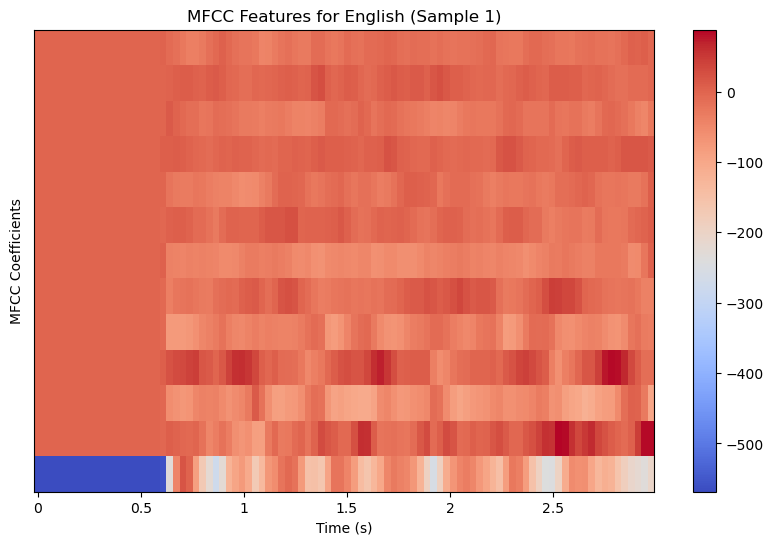

In [3]:
import matplotlib.pyplot as plt
import librosa.display

# Select one audio clip to visualize
example_index = 0  # Change this to visualize other samples
example_mfcc = features[example_index]
example_label = labels[example_index]

# Plot the MFCC features
plt.figure(figsize=(10, 6))
librosa.display.specshow(example_mfcc.T, sr=16000, x_axis='time', cmap='coolwarm')
plt.colorbar()
plt.title(f'MFCC Features for {example_label} (Sample {example_index + 1})')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.show()


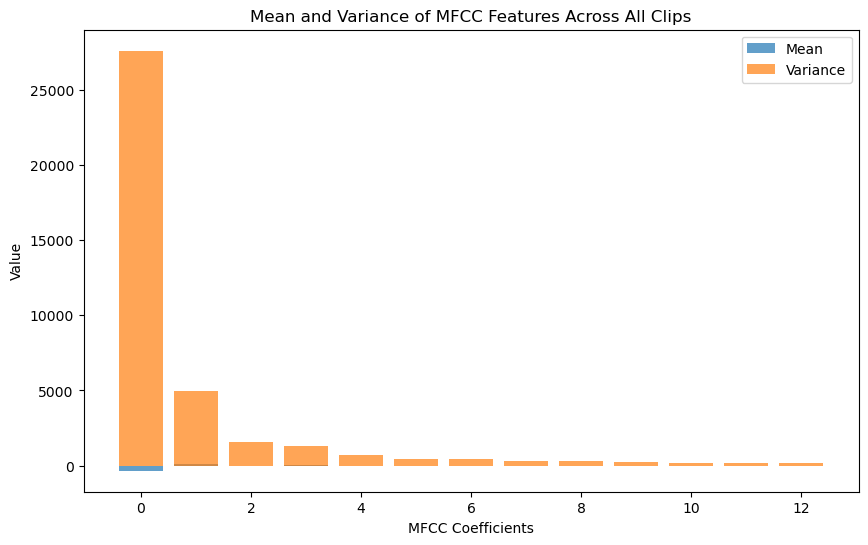

In [4]:
# Calculate mean and variance for each MFCC coefficient across all samples
mfcc_features = np.concatenate(features, axis=0)  # Combine all MFCC features
mean_mfcc = np.mean(mfcc_features, axis=0)
var_mfcc = np.var(mfcc_features, axis=0)

# Plot mean and variance
plt.figure(figsize=(10, 6))
plt.bar(range(len(mean_mfcc)), mean_mfcc, alpha=0.7, label='Mean')
plt.bar(range(len(var_mfcc)), var_mfcc, alpha=0.7, label='Variance')
plt.xlabel('MFCC Coefficients')
plt.ylabel('Value')
plt.title('Mean and Variance of MFCC Features Across All Clips')
plt.legend()
plt.show()


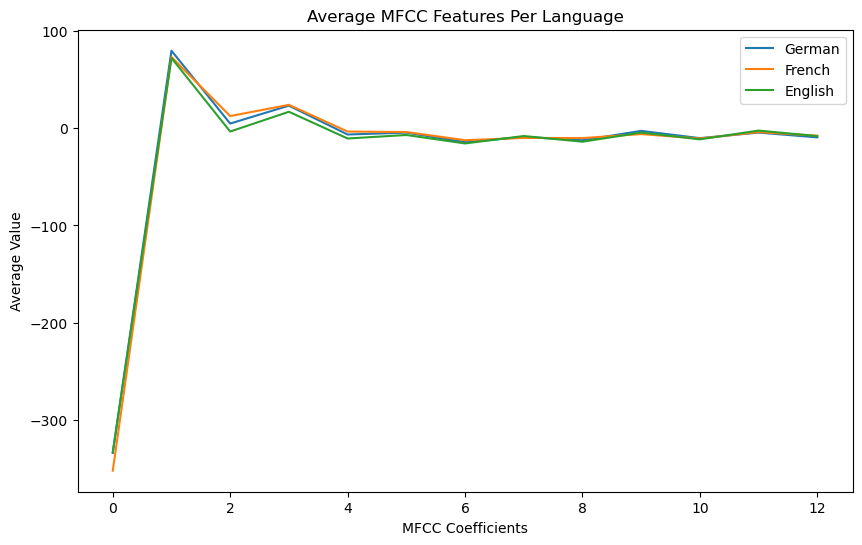

In [5]:
# Group MFCC features by language and calculate mean
language_means = {language: np.mean(np.concatenate(
    [features[i] for i, lbl in enumerate(labels) if lbl == language], axis=0), axis=0)
                  for language in set(labels)}

# Plot average MFCCs for each language
plt.figure(figsize=(10, 6))
for language, mean_values in language_means.items():
    plt.plot(mean_values, label=language)

plt.xlabel('MFCC Coefficients')
plt.ylabel('Average Value')
plt.title('Average MFCC Features Per Language')
plt.legend()
plt.show()


In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import pad_sequences, to_categorical

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)  # Convert language labels to numeric

# Pad sequences to ensure uniform length
max_length = max([f.shape[0] for f in features])  # Longest sequence length
padded_features = pad_sequences(features, maxlen=max_length, dtype='float32', padding='post')

# Convert labels to one-hot encoding
categorical_labels = to_categorical(encoded_labels)

print(f"Feature shape: {padded_features.shape}")
print(f"Label shape: {categorical_labels.shape}")



Feature shape: (15386, 94, 13)
Label shape: (15386, 3)


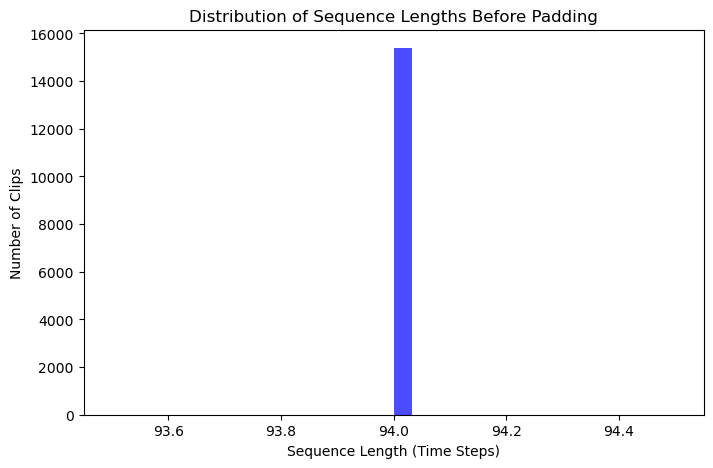

In [7]:
import matplotlib.pyplot as plt

# Calculate sequence lengths
sequence_lengths = [f.shape[0] for f in features]

# Plot distribution of sequence lengths
plt.figure(figsize=(8, 5))
plt.hist(sequence_lengths, bins=30, color='blue', alpha=0.7)
plt.xlabel('Sequence Length (Time Steps)')
plt.ylabel('Number of Clips')
plt.title('Distribution of Sequence Lengths Before Padding')
plt.show()


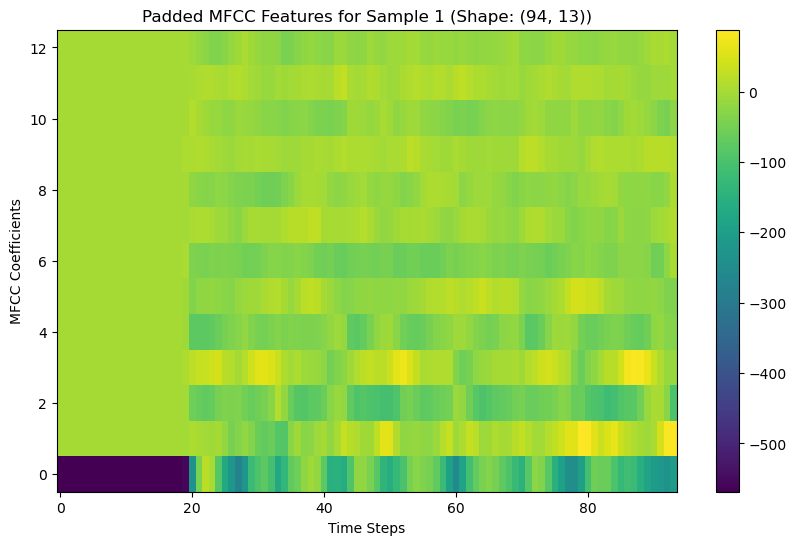

In [8]:
import librosa.display
import numpy as np

# Select a sample to visualize
sample_index = 0  # Change this index to visualize other samples
sample_features = padded_features[sample_index]

# Plot the padded feature matrix
plt.figure(figsize=(10, 6))
plt.imshow(sample_features.T, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar()
plt.title(f"Padded MFCC Features for Sample {sample_index + 1} (Shape: {sample_features.shape})")
plt.xlabel('Time Steps')
plt.ylabel('MFCC Coefficients')
plt.show()


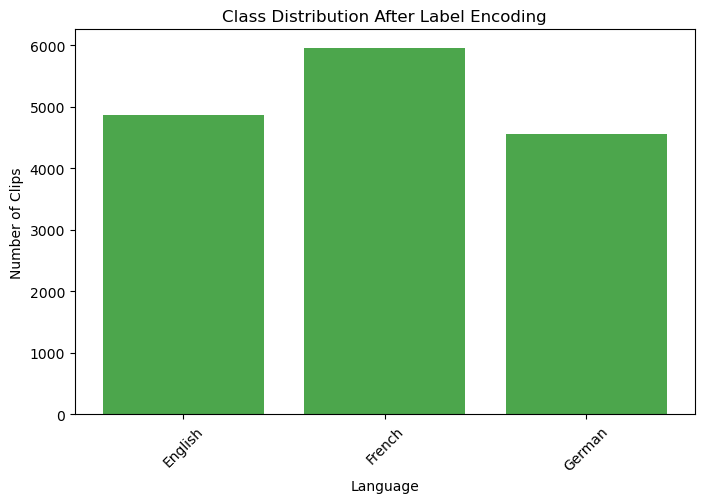

Label Mapping:
0: English
1: French
2: German


In [9]:
# Calculate class distribution
unique, counts = np.unique(encoded_labels, return_counts=True)
class_distribution = dict(zip(label_encoder.classes_, counts))

# Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_distribution.keys(), class_distribution.values(), color='green', alpha=0.7)
plt.xlabel('Language')
plt.ylabel('Number of Clips')
plt.title('Class Distribution After Label Encoding')
plt.xticks(rotation=45)
plt.show()

# Print class mapping
print("Label Mapping:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"{idx}: {label}")


In [47]:
# Display the first 10 labels before encoding
print("Sample Labels Before Encoding:")
print(labels[:10])  # Replace 'labels' with your variable storing original labels


Sample Labels Before Encoding:
['English', 'English', 'English', 'English', 'English', 'English', 'English', 'English', 'English', 'English']


In [51]:
# Display label mapping
print("Label Mapping:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"{idx}: {label}")


Label Mapping:
0: English
1: French
2: German


In [48]:
# Display the first 10 encoded labels
print("Sample Labels After Encoding (Numeric):")
print(encoded_labels[:10])


Sample Labels After Encoding (Numeric):
[0 0 0 0 0 0 0 0 0 0]


In [10]:
# Display the first 5 one-hot encoded labels
print("Sample Labels After One-Hot Encoding:")
print(categorical_labels[:5])


Sample Labels After One-Hot Encoding:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical, pad_sequences
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings("ignore")



X = np.expand_dims(padded_features, -1)  # Add a channel dimension for CNN
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define RNN model
rnn_model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile RNN model
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train RNN model
rnn_history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))





Epoch 1/50


385/385 [==============================] - 30s 71ms/step - loss: 0.8869 - accuracy: 0.5837 - val_loss: 0.7994 - val_accuracy: 0.6589
Epoch 2/50
385/385 [==============================] - 25s 65ms/step - loss: 0.7408 - accuracy: 0.6887 - val_loss: 0.7148 - val_accuracy: 0.6985
Epoch 3/50
385/385 [==============================] - 26s 66ms/step - loss: 0.6555 - accuracy: 0.7287 - val_loss: 0.6424 - val_accuracy: 0.7359
Epoch 4/50
385/385 [==============================] - 25s 65ms/step - loss: 0.5974 - accuracy: 0.7516 - val_loss: 0.6035 - val_accuracy: 0.7537
Epoch 5/50
385/385 [==============================] - 25s 65ms/step - loss: 0.5475 - accuracy: 0.7798 - val_loss: 0.5612 - val_accuracy: 0.7820
Epoch 6/50
385/385 [==============================] - 25s 65ms/step - loss: 0.5166 - accuracy: 0.7914 - val_loss: 0.5341 - val_accuracy: 0.7976
Epoch 7/50
385/385 [==============================] - 25s 65ms/step - loss: 0.4779 - accuracy: 0.8078 - val_loss: 0.5268 - val_accur

In [12]:
# Print the RNN model architecture
print("RNN Model Summary:")
rnn_model.summary()


RNN Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 94, 128)           72704     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 130819 (511.01 KB)
Trainable params: 130819 (511.01 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________________

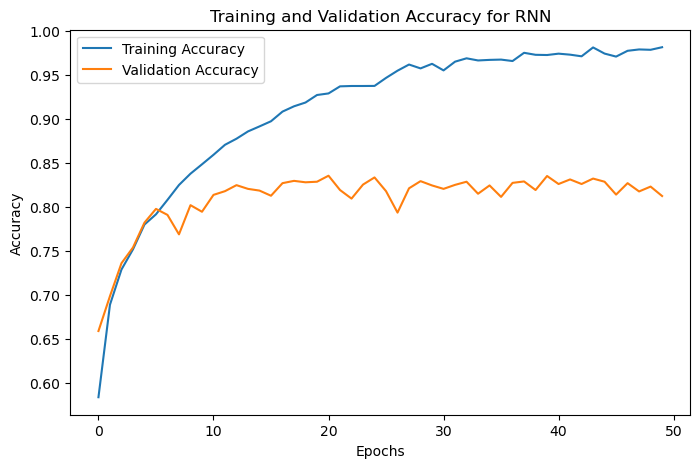

In [13]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(rnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for RNN')
plt.legend()
plt.show()


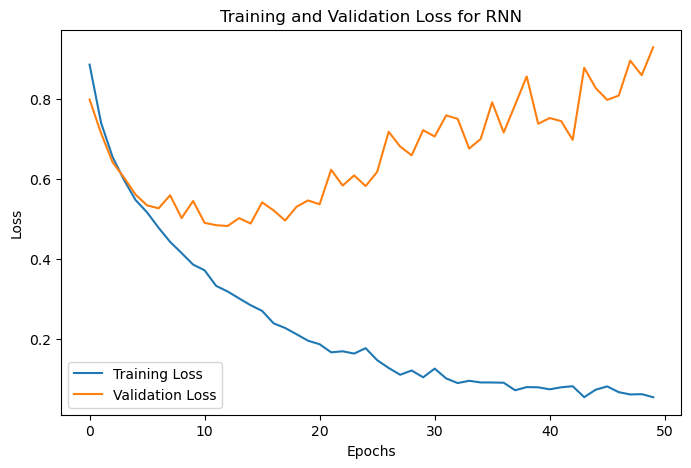

In [14]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for RNN')
plt.legend()
plt.show()


In [15]:
# Final evaluation on validation set
final_loss, final_accuracy = rnn_model.evaluate(X_val, y_val, verbose=0)

print(f"Final Validation Loss: {final_loss:.4f}")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")


Final Validation Loss: 0.9305
Final Validation Accuracy: 0.8122


RNN Validation Loss: 0.9305
RNN Validation Accuracy: 0.8122
97/97 [==============================] - 3s 21ms/step


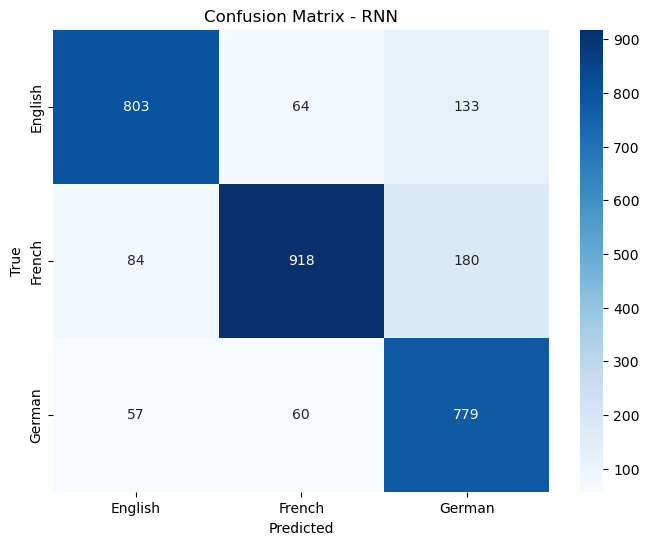

Classification Report - RNN:
              precision    recall  f1-score   support

     English       0.85      0.80      0.83      1000
      French       0.88      0.78      0.83      1182
      German       0.71      0.87      0.78       896

    accuracy                           0.81      3078
   macro avg       0.82      0.82      0.81      3078
weighted avg       0.82      0.81      0.81      3078



In [16]:
import numpy as np  # For array manipulation and numeric operations
import matplotlib.pyplot as plt  # For visualizing confusion matrix
import seaborn as sns  # For visualizing confusion matrix as a heatmap
from sklearn.metrics import confusion_matrix, classification_report  # For confusion matrix and classification report


# Evaluate RNN model
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_val, y_val, verbose=0)
print(f"RNN Validation Loss: {rnn_loss:.4f}")
print(f"RNN Validation Accuracy: {rnn_accuracy:.4f}")

# Predictions
y_pred_rnn = np.argmax(rnn_model.predict(X_val), axis=1)

# Confusion Matrix
cm_rnn = confusion_matrix(y_val, y_pred_rnn)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - RNN')
plt.show()

# Classification Report
print("Classification Report - RNN:")
print(classification_report(y_val, y_pred_rnn, target_names=label_encoder.classes_))


In [66]:
import pandas as pd

# Compare predictions to actual values
misclassified_indices = np.where(y_val != y_pred_rnn)[0]

# Create a DataFrame of misclassified samples
misclassified_df = pd.DataFrame({
    'True Label': [label_encoder.inverse_transform([y_val[i]])[0] for i in misclassified_indices],
    'Predicted Label': [label_encoder.inverse_transform([y_pred_rnn[i]])[0] for i in misclassified_indices]
})

# Display some misclassifications
print("Sample Misclassified Predictions:")
print(misclassified_df.head(10))  # Show first 10 misclassified samples


Sample Misclassified Predictions:
  True Label Predicted Label
0     German         English
1     German         English
2     German          French
3     German          French
4    English          German
5     French         English
6    English          German
7    English          French
8     German          French
9    English          German


In [17]:
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa.display

# Path to your unseen audio file (update this path)
unseen_audio_path = 'common_voice_fr_40158731.mp3'  # Replace this with the actual path to your audio file

def preprocess_audio(file_path, n_mfcc=13, sr=16000, duration=3, max_length=150):  # max_length should match the training logic
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        
        # Load the audio file and force resampling to 16 kHz
        audio, sr = librosa.load(file_path, sr=sr, duration=duration)
        
        # Print information for debugging
        print(f"Loaded audio with {len(audio)} samples at {sr} Hz")
        
        # Pad if audio is shorter than the required duration
        if len(audio) < sr * duration:
            print(f"Audio too short, padding from {len(audio)} to {sr * duration} samples")
            audio = np.pad(audio, (0, sr * duration - len(audio)), 'constant')
        
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        
        # Transpose to shape (time_steps, n_mfcc)
        mfcc = mfcc.T
        
        # Pad the MFCCs to match the input shape expected by the RNN
        if mfcc.shape[0] < max_length:
           # print(f"MFCC too short, padding from {mfcc.shape[0]} to {max_length} time steps")
            mfcc = np.pad(mfcc, ((0, max_length - mfcc.shape[0]), (0, 0)), mode='constant')
        else:
            mfcc = mfcc[:max_length, :]
        
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


# Preprocess the unseen audio file
unseen_features = preprocess_audio(unseen_audio_path, max_length=150)  # Update max_length based on model input size

# Check if the features were extracted properly
if unseen_features is not None:
    # Visualize MFCC features for unseen data
    #plt.figure(figsize=(10, 6))
    #librosa.display.specshow(unseen_features.T, sr=16000, x_axis='time', cmap='coolwarm')
    #plt.colorbar()
    #plt.title('MFCC Features of Unseen Audio Clip')
    #plt.xlabel('Time (s)')
    #plt.ylabel('MFCC Coefficients')
    #plt.show()
    
    # Reshape to match the input shape of the model
    unseen_features = np.expand_dims(unseen_features, axis=0)  # Add batch dimension
    unseen_features = np.expand_dims(unseen_features, axis=-1)  # Add channel dimension for CNN/RNN
    
    # Predict the language using the RNN model
    predictions = rnn_model.predict(unseen_features)
    predicted_class_index = np.argmax(predictions)
    predicted_language = label_encoder.inverse_transform([predicted_class_index])[0]

    #print(f"Predicted Class Index: {predicted_class_index}")
    print(f"Predicted Language: {predicted_language}")
    #print(f"Prediction Confidence Scores: {predictions[0]}")



Loaded audio with 48000 samples at 16000 Hz
1/1 [==============================] - 0s 473ms/step
Predicted Language: French


In [17]:
from keras_tuner import Hyperband
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('units_1', min_value=64, max_value=256, step=64),
                   input_shape=(94, 13), return_sequences=True))
    model.add(LSTM(hp.Int('units_2', min_value=32, max_value=128, step=32)))
    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Instantiate Keras Tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='my_tuning',
    project_name='language_identification'
)

# Start hyperparameter search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best units for LSTM 1: {best_hps.get('units_1')}")
print(f"Best units for LSTM 2: {best_hps.get('units_2')}")
print(f"Best dropout rate: {best_hps.get('dropout_rate')}")


Trial 30 Complete [00h 07m 53s]
val_accuracy: 0.8154646158218384

Best val_accuracy So Far: 0.8349577784538269
Total elapsed time: 01h 18m 17s
Best units for LSTM 1: 256
Best units for LSTM 2: 96
Best dropout rate: 0.2


In [18]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Rebuild the model with the best hyperparameters
final_model = Sequential()
final_model.add(LSTM(best_hps.get('units_1'), input_shape=(94, 13), return_sequences=True))
final_model.add(LSTM(best_hps.get('units_2')))
final_model.add(Dense(best_hps.get('dense_units'), activation='relu'))
final_model.add(Dropout(best_hps.get('dropout_rate')))
final_model.add(Dense(3, activation='softmax'))

# Compile the model
final_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])


In [19]:
# Train the model
final_history = final_model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val), 
                                epochs=20,  # You can adjust this based on results
                                batch_size=32)


Epoch 1/20
385/385 [==============================] - 38s 90ms/step - loss: 0.8761 - accuracy: 0.6026 - val_loss: 0.7854 - val_accuracy: 0.6546
Epoch 2/20
385/385 [==============================] - 56s 145ms/step - loss: 0.7307 - accuracy: 0.6904 - val_loss: 0.6998 - val_accuracy: 0.7018
Epoch 3/20
385/385 [==============================] - 80s 208ms/step - loss: 0.6624 - accuracy: 0.7221 - val_loss: 0.6348 - val_accuracy: 0.7255
Epoch 4/20
385/385 [==============================] - 79s 205ms/step - loss: 0.5786 - accuracy: 0.7631 - val_loss: 0.5759 - val_accuracy: 0.7567
Epoch 5/20
385/385 [==============================] - 78s 202ms/step - loss: 0.5134 - accuracy: 0.7937 - val_loss: 0.5153 - val_accuracy: 0.7963
Epoch 6/20
385/385 [==============================] - 84s 217ms/step - loss: 0.4685 - accuracy: 0.8144 - val_loss: 0.5205 - val_accuracy: 0.7908
Epoch 7/20
385/385 [==============================] - 79s 204ms/step - loss: 0.4310 - accuracy: 0.8286 - val_loss: 0.4795 - val_acc

In [20]:
# Evaluate the final model
final_loss, final_accuracy = final_model.evaluate(X_val, y_val, verbose=0)
print(f"Final Validation Loss: {final_loss:.4f}")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")


Final Validation Loss: 0.5030
Final Validation Accuracy: 0.8372


In [21]:
import numpy as np

# Predict class labels for validation set
y_pred_final = np.argmax(final_model.predict(X_val), axis=1)


97/97 [==============================] - 4s 30ms/step


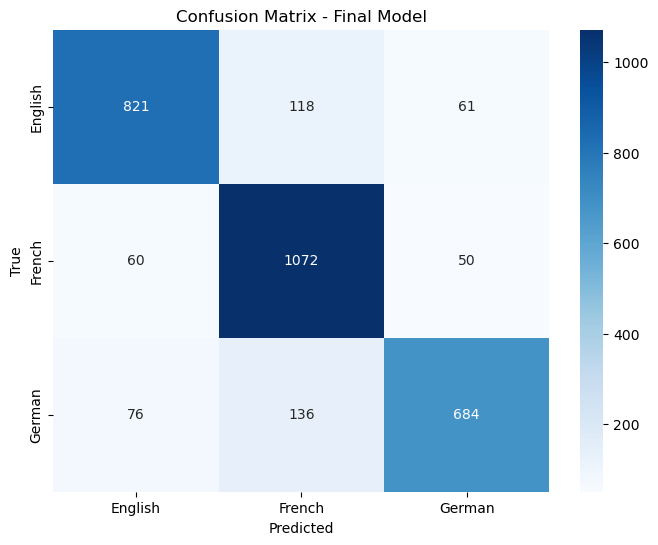

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm_final = confusion_matrix(y_val, y_pred_final)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Final Model')
plt.show()


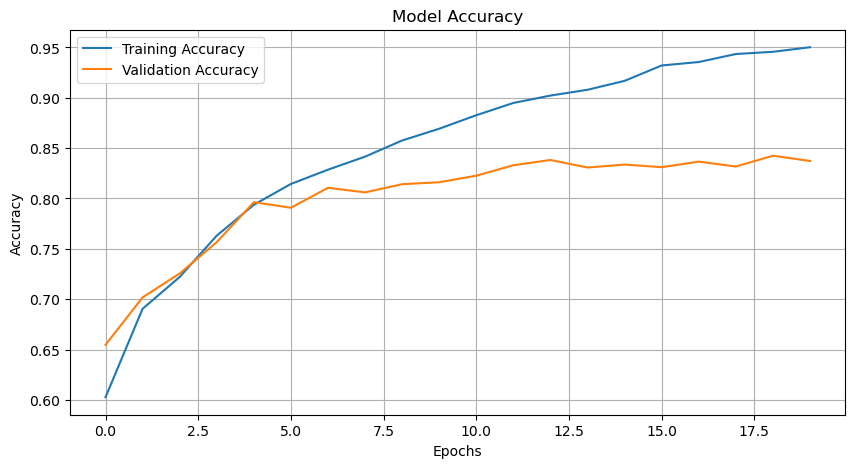

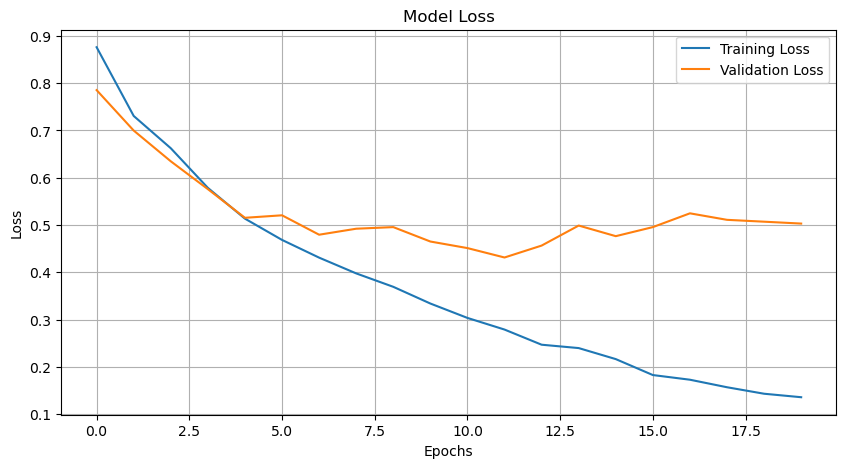

In [23]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(final_history.history['accuracy'], label='Training Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
